### **1. Importing packages**

In [ ]:
#Main Libraries
import os
import pandas as pd
import numpy as np
import random
import string
import os
import random
import glob

#Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
seed=11


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import BayesianOptimization
import hyperopt
from hyperopt import fmin, tpe, hp

In [ ]:
import seaborn as sns

In [ ]:

import matplotlib as plt

In [ ]:
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder


### **2. Importing the dataset from training directory**

In [ ]:
TRAIN_PATH = "C:\\Users\\sg709\\Downloads\\ASL_Dataset\\asl_alphabet_train\\asl_alphabet_train\\"

In [ ]:
def set_seed_for_everything(seed):
  # Set the seed for the built-in Python random number generator.
  random.seed(seed)

  # Set the seed for Python's hash function, which affects hash-based data structures.
  os.environ["PYTHONHASHSEED"] = str(seed)

  # Set the seed for the NumPy random number generator.
  np.random.seed(seed)

  # Set the seed for the TensorFlow random number generator.
  tf.random.set_seed(seed)

# Call the function to set the seeds for various random number generators.
set_seed_for_everything(seed)


In [ ]:
labels = []  # Initialize an empty list named "labels".

# Create a list of uppercase letters in the English alphabet using the string module's ascii_uppercase.
alphabet = list(string.ascii_uppercase)

# Extend the "labels" list with the elements from the "alphabet" list.
labels.extend(alphabet)

# Extend the "labels" list with three additional custom elements.
labels.extend(["del", "nothing", "space"])

# Print the final "labels" list.
print(labels)


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
# Initialize empty lists to store image paths and labels.
list_path = []
list_labels = []

# Create a DataFrame using a dictionary, where "image_path" corresponds to "list_path"
# and "label" corresponds to "list_labels".
character_path_for_words_df = pd.DataFrame({"image_path": list_path, "label": list_labels})

In [ ]:
def create_image_paths(each_class_size=10, label="A", seednumber=11):
    random.seed(seednumber)  # Set the seed for random number generation.

    list_path = []  # List to store generated image paths.
    labels_len = []  # List to store labels for the generated images.

    label_path = os.path.join(TRAIN_PATH, label)  # Construct the path to the images of the specified label.
    image_paths = glob.glob(label_path + '/*.jpg')  # Get a list of image paths with the specified label.

    # Select "each_class_size" random image paths from the available images.
    random_image_paths = random.sample(image_paths, each_class_size)
    list_path.append(random_image_paths)  # Append the selected image paths to the list.

    # Create a list of labels corresponding to the randomly selected image paths.
    labels_len = [label] * each_class_size

    return list_path, labels_len  # Return the list of image paths and the corresponding labels.


# list_paths=[]
# labels_lens=[]
# list_paths, labels_lens = create_image_paths(each_class_size=10,label="A", seednumber = seed)
# print(list_paths)
# print(len(labels_lens))

In [ ]:
# This function generates a subset of image data for multiple classes, with specified parameters.

def create_subset_of_image_data(each_class_size=10, labels=labels, seednumber=seed):
    list_path = []  # Initialize a list to store the generated image paths.
    list_labels = []  # Initialize a list to store the corresponding labels for the images.

    # Loop through each label to generate data for multiple classes.
    for label in labels:
        gen_paths = []  # Initialize a list to hold image paths for the current label.
        gen_labels = []  # Initialize a list to hold labels for the current label.
        class_size = each_class_size  # Determine the number of images to generate per class.

        # Generate random image paths and labels for the current class.
        gen_paths, gen_labels = create_image_paths(each_class_size=class_size, label=label, seednumber=seed)

        # Extend the main lists with the generated image paths and labels for the current class.
        list_path.extend(gen_paths[0])  # Assuming gen_paths[0] contains the list of image paths.
        list_labels.extend(gen_labels)

    # Create a pandas DataFrame to store the subset of image data.
    subset_df = pd.DataFrame({"image_path": list_path, "label": list_labels})
    return subset_df

# Example usage to create a subset of image data for each class.
images_per_class = 2000
subset_df = create_subset_of_image_data(each_class_size=images_per_class, labels=labels, seednumber=seed)

# Display the first few rows of the generated DataFrame for inspection.
print(subset_df.head())


,image_path,label
0,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,A
1,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,A
2,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,A
3,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,A
4,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,A


In [ ]:
subset_df.tail()

,image_path,label
57995,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,space
57996,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,space
57997,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,space
57998,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,space
57999,C:\Users\sg709\Downloads\ASL_Dataset\asl_alpha...,space


In [ ]:
def sample_images(labels, subset_df):
    # Create subplots to display sample images from the dataset.
    y_size = 12

    # Adjust the height of the subplot layout based on the number of labels.
    # Ensure that the layout is not too large for a large number of labels.
    if len(labels) < 10:
        y_size = y_size * len(labels) / 10

    # Create subplots layout based on the number of labels and columns.
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    # Iterate through each label to display sample images.
    for i, label in enumerate(labels):
        # Set the first column for label text.
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        # Get a list of image paths for the current label.
        list_files = subset_df[subset_df['label'] == label]['image_path'].tolist()

        # Display up to 8 sample images for the current label.
        for j in range(8):
            img_label = cv2.imread(list_files[j])  # Load an image from the list.
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)  # Convert image to RGB format.
            axs[i, j+1].imshow(img_label)  # Display the image in the subplot.
            axs[i, j+1].axis("off")  # Turn off axis for the image subplot.

    # Set a title for the entire visualization.
    plt.suptitle("Sample Images in American Sign Language Dataset", x=0.55, y=0.92)

    # Display the subplots.
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

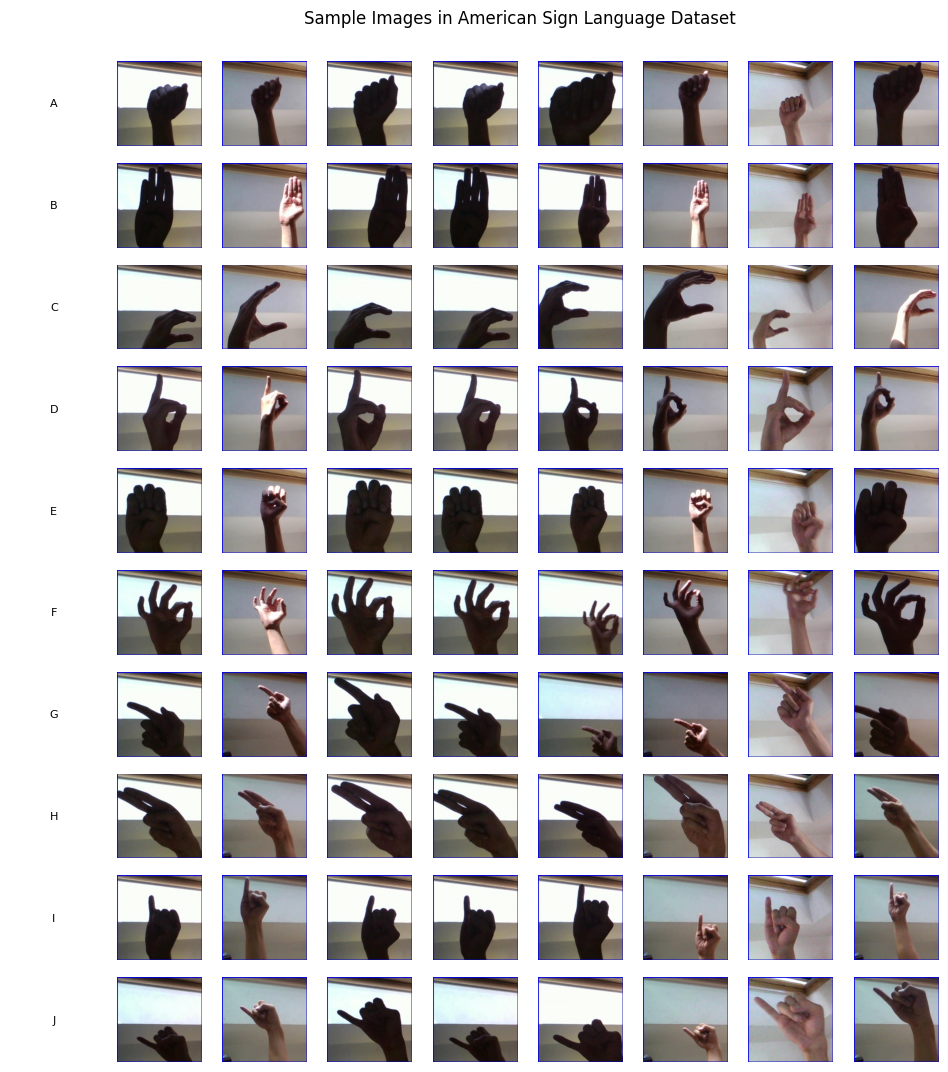

In [ ]:
# Display a visualization of sample images from the subset dataset using the 'sample_images' function.
# The function takes two arguments: a list of the first 10 labels and the DataFrame 'subset_df' containing image paths and labels.
sample_images(labels[:10], subset_df)


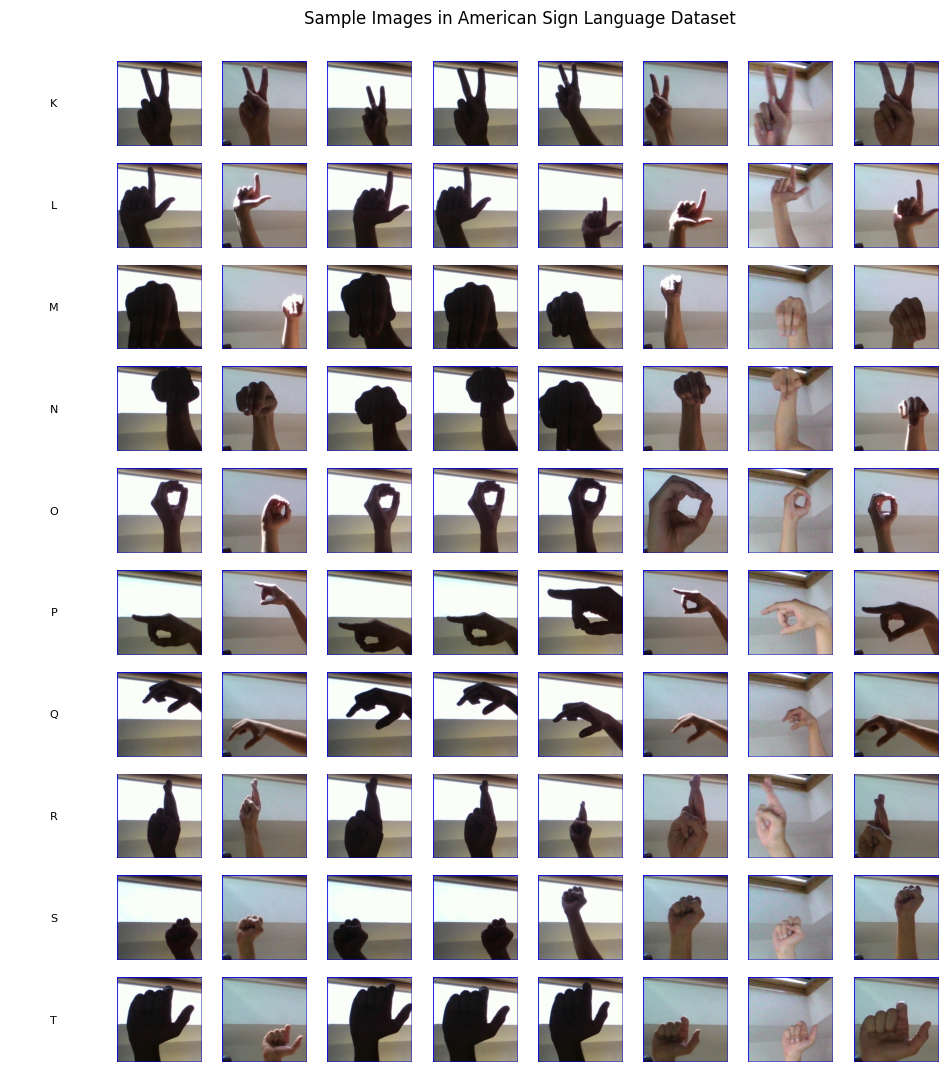

In [ ]:
# Display a visualization of sample images from the subset dataset using the 'sample_images' function.
# The function takes two arguments: a sublist of labels from index 10 to 19 and the DataFrame 'subset_df' containing image paths and labels.
sample_images(labels[10:20], subset_df)


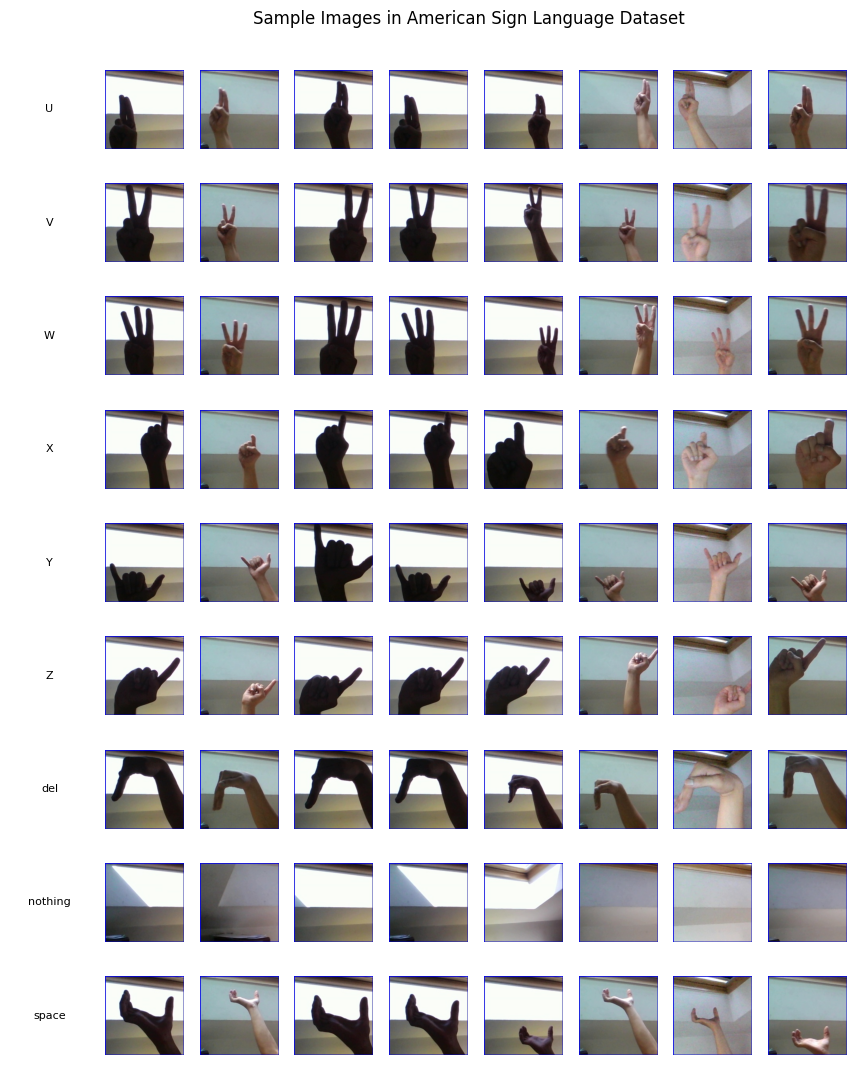

In [ ]:
# Display a visualization of sample images from the subset dataset using the 'sample_images' function.
# The function takes two arguments: a sublist of labels from index 20 onwards and the DataFrame 'subset_df' containing image paths and labels.
sample_images(labels[20:], subset_df)


In [ ]:
# Set the batch size for training.
batch_size = 64

# Define the desired dimensions for the input images.
imageSize = 64

# Define the target dimensions for the input images in the format (height, width, channels).
target_dims = (imageSize, imageSize, 3)

# Calculate the total number of training samples based on the number of images per class and the number of labels.
# In this case, 10 images will be randomly selected for each of the 29 classes.
train_len = images_per_class * len(labels)


58000

In [ ]:
def data_augmentation(subset_df, train_len, imageSize):
    # Extract image paths and labels from the subset DataFrame.
    image_paths = subset_df.iloc[:, 0]
    image_paths_list = image_paths.tolist()
    labels = subset_df.iloc[:, 1]
    labels_list = labels.tolist()

    # Initialize arrays to hold image data and labels.
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=int)
    cnt = 0

    # Load and preprocess images from image_paths_list.
    for img_file in image_paths_list:
        img_file_path = str(img_file)
        img = cv2.imread(img_file_path)
        img = skimage.transform.resize(img, (imageSize, imageSize, 3))
        img_arr = np.asarray(img).reshape((-1, imageSize, imageSize, 3))
        X[cnt] = img_arr
        cnt += 1

    # Encode class labels using LabelEncoder.
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_list)
    y = np.array(labels_encoded)

    # Get the mapping of encoded labels to their original class labels.
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    return X, y, label_mapping

# Call the data_augmentation function to preprocess image data and labels.
X_train, y_train, label_mapping = data_augmentation(subset_df, train_len, imageSize)

# Print a message to indicate that the images have been successfully imported and preprocessed.
print("Images successfully imported...")


Images successfully imported...


### **2.1 Checking the shape of data**

In [ ]:
# Print the shape of the training data (X_train) and corresponding labels (y_train).
print("The shape of X_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)

The shape of X_train is :  (58000, 64, 64, 3)
The shape of y_train is :  (58000,)


### **2.2 Checking the shape of one image**

In [ ]:
# Print the shape of a single image in the training data (X_train).
print("The shape of one image is:", X_train[0].shape)

The shape of one image is :  (64, 64, 3)


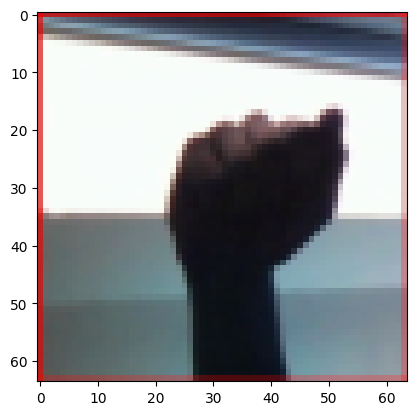

In [ ]:
# Display the first image in the training data (X_train) using the 'plt.imshow' function.
plt.imshow(X_train[0])

# Display the plot.
plt.show()


### **2.3.1 Making copies of original data**

In [ ]:
# Assign the training image data (X_train) to the variable X_data.
X_data = X_train

# Assign the training labels (y_train) to the variable y_data.
y_data = y_train



### **3. Data processing**

### **3.1 Train/test split**

In [ ]:
from sklearn.model_selection import train_test_split

# Perform train-test split on the dataset using the 'train_test_split' function.
# The function separates the data into training and testing subsets.
# 'test_size=0.3' specifies that 30% of the data will be used for testing.
# 'random_state=42' ensures reproducibility of the split.
# 'stratify=y_data' maintains the proportion of class labels in both subsets.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)


### **3.2 One-Hot-Encoding**

In [ ]:
# Import the 'to_categorical' function from TensorFlow for one-hot encoding.
from tensorflow.keras.utils import to_categorical

# Convert the training labels (y_train) into one-hot encoded format.
y_cat_train = to_categorical(y_train, num_classes=29)

# Convert the testing labels (y_test) into one-hot encoded format.
y_cat_test = to_categorical(y_test, num_classes=29)


### **3.3 Dimension Check of variables**

In [ ]:
# Print the dimensions (shapes) of different variables to check their sizes.
print("Shape of X_train:", X_train.shape)  # Shape of training images
print("Shape of y_train:", y_train.shape)  # Shape of training labels
print("Shape of X_test:", X_test.shape)  # Shape of testing images
print("Shape of y_test:", y_test.shape)  # Shape of testing labels
print("Shape of y_cat_train:", y_cat_train.shape)  # Shape of one-hot encoded training labels
print("Shape of y_cat_test:", y_cat_test.shape)  # Shape of one-hot encoded testing labels


(40600, 64, 64, 3)
(40600,)
(17400, 64, 64, 3)
(17400,)
(40600, 29)
(17400, 29)


### **5. Modeling**

### **5.1 Importing packages**

In [ ]:
# Import the necessary classes and functions from Keras for building a CNN model.
from keras.models import Sequential  # Import the Sequential model class
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, BatchNormalization, Dropout
# Import various layers and components used in constructing the CNN architecture.

# Print a message to indicate that the required packages have been imported.
print("Packages imported...")


Packages imported...


### **5.2 Hyperparameter Tuning with Bayesian Optimization for CNN Architecture**

Output width:
Output width = (Input width - Kernel width) + 1
Output width = (64 - 5) + 1 = 60

Output height:
Output height = (Input height - Kernel height) + 1
Output height = (64 - 5) + 1 = 60

Output channels (number of filters):
The number of filters specified in the layer, which is 32.

In [ ]:
# Import necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from kerastuner.tuners import BayesianOptimization

# Define a function to build the model with hyperparameters provided by the Keras Tuner
def build_model(hp):
    model = Sequential()

    # Define hyperparameters to search for second convolutional layer neurons and dense layer neurons
    hp_second_conv_neurons = hp.Choice("second_conv_neurons", values=[64, 128, 256])
    hp_second_dense_neurons = hp.Choice("second_dense_neurons", values=[256, 512, 1024])
    hp_third_dense_neurons = hp.Choice("third_dense_neurons", values=[256, 1024, 2048])

    # Define hyperparameter for activation function
    hp_activation = hp.Choice('activation', values=['tanh', 'relu', 'elu'])

    # Build the model architecture with hyperparameters
    model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
    model.add(Activation(hp_activation))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(hp_second_conv_neurons, (3, 3)))
    model.add(Activation(hp_activation))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation=hp_activation))
    model.add(Dropout(0.5))

    model.add(Dense(hp_second_dense_neurons, activation=hp_activation))
    model.add(Dropout(0.5))

    model.add(Dense(hp_third_dense_neurons, activation=hp_activation))
    model.add(Dropout(0.5))

    model.add(Dense(29, activation='softmax'))

    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

# Initialize the BayesianOptimization tuner with build_model function and objective "val_loss"
# Set max_trials to limit the number of hyperparameter search trials
tuner = BayesianOptimization(build_model, objective="val_loss", max_trials=10, overwrite=True)

# Define EarlyStopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Start hyperparameter search using the tuner
tuner.search(X_train, y_cat_train, epochs=50, batch_size=64, validation_data=(X_test, y_cat_test), shuffle=True, callbacks=[stop_early])

# Get the best hyperparameters found by the tuner
best_hyp = tuner.get_best_hyperparameters(1)[0]
print(best_hyp.values)


Trial 10 Complete [00h 13m 28s]
val_loss: 0.14427810907363892

Best val_loss So Far: 0.011065836995840073
Total elapsed time: 04h 02m 28s
INFO:tensorflow:Oracle triggered exit
{'second_conv_neurons': 256, 'second_dense_neurons': 256, 'third_dense_neurons': 1024, 'activation': 'relu'}


In [ ]:
# Display a summary of the results from the hyperparameter tuning process
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
second_conv_neurons: 256
second_dense_neurons: 256
third_dense_neurons: 1024
activation: relu
Score: 0.011065836995840073

Trial 04 summary
Hyperparameters:
second_conv_neurons: 128
second_dense_neurons: 1024
third_dense_neurons: 256
activation: relu
Score: 0.012786580249667168

Trial 00 summary
Hyperparameters:
second_conv_neurons: 256
second_dense_neurons: 1024
third_dense_neurons: 1024
activation: relu
Score: 0.012987968511879444

Trial 02 summary
Hyperparameters:
second_conv_neurons: 64
second_dense_neurons: 256
third_dense_neurons: 1024
activation: relu
Score: 0.016844475641846657

Trial 06 summary
Hyperparameters:
second_conv_neurons: 128
second_dense_neurons: 256
third_dense_neurons: 1024
activation: elu
Score: 0.060360513627529144

Trial 01 summary
Hyperparameters:
second_conv_neurons: 64
second_dense_neurons: 512
third_dense_neuron

In [ ]:
# Get the top 2 models found during hyperparameter tuning.
models = tuner.get_best_models(num_models=2)

# Select the best model (the first model in the list of top models).
best_model = models[0]

# Build the selected best model by specifying the input shape.
# This is needed for Sequential models when the input shape is not explicitly specified in the layers.
best_model.build(input_shape=(None, 28, 28))

# Display a summary of the best model's architecture.
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       73984     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                    

In [ ]:
results = tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
second_conv_neurons: 256
second_dense_neurons: 256
third_dense_neurons: 1024
activation: relu
Score: 0.011065836995840073

Trial 04 summary
Hyperparameters:
second_conv_neurons: 128
second_dense_neurons: 1024
third_dense_neurons: 256
activation: relu
Score: 0.012786580249667168

Trial 00 summary
Hyperparameters:
second_conv_neurons: 256
second_dense_neurons: 1024
third_dense_neurons: 1024
activation: relu
Score: 0.012987968511879444

Trial 02 summary
Hyperparameters:
second_conv_neurons: 64
second_dense_neurons: 256
third_dense_neurons: 1024
activation: relu
Score: 0.016844475641846657

Trial 06 summary
Hyperparameters:
second_conv_neurons: 128
second_dense_neurons: 256
third_dense_neurons: 1024
activation: elu
Score: 0.060360513627529144

Trial 01 summary
Hyperparameters:
second_conv_neurons: 64
second_dense_neurons: 512
third_dense_neuron

In [ ]:
type(results)

NoneType

In [ ]:
import pandas as pd

# Sample data you've provided
trial_data = [
    {
        'Trial': 'Trial 05',
        'second_conv_neurons': 256,
        'second_dense_neurons': 256,
        'third_dense_neurons': 1024,
        'activation': 'relu',
        'Score': 0.011065836995840073
    },
    {
        'Trial': 'Trial 04',
        'second_conv_neurons': 128,
        'second_dense_neurons': 1024,
        'third_dense_neurons': 256,
        'activation': 'relu',
        'Score': 0.012786580249667168
    },
    {
        'Trial': 'Trial 00',
        'second_conv_neurons': 256,
        'second_dense_neurons': 1024,
        'third_dense_neurons': 1024,
        'activation': 'relu',
        'Score': 0.012987968511879444
    },
    {
        'Trial': 'Trial 02',
        'second_conv_neurons': 64,
        'second_dense_neurons': 256,
        'third_dense_neurons': 1024,
        'activation': 'relu',
        'Score': 0.016844475641846657
    },
    {
        'Trial': 'Trial 06',
        'second_conv_neurons': 128,
        'second_dense_neurons': 256,
        'third_dense_neurons': 1024,
        'activation': 'elu',
        'Score': 0.060360513627529144
    },
    {
        'Trial': 'Trial 01',
        'second_conv_neurons': 64,
        'second_dense_neurons': 512,
        'third_dense_neurons': 2048,
        'activation': 'tanh',
        'Score': 0.07713884860277176
    },
    {
        'Trial': 'Trial 08',
        'second_conv_neurons': 128,
        'second_dense_neurons': 256,
        'third_dense_neurons': 2048,
        'activation': 'elu',
        'Score': 0.1145244836807251
    },
    {
        'Trial': 'Trial 03',
        'second_conv_neurons': 128,
        'second_dense_neurons': 512,
        'third_dense_neurons': 1024,
        'activation': 'elu',
        'Score': 0.125639870762825
    },
    {
        'Trial': 'Trial 09',
        'second_conv_neurons': 64,
        'second_dense_neurons': 256,
        'third_dense_neurons': 2048,
        'activation': 'elu',
        'Score': 0.14427810907363892
    },
    {
        'Trial': 'Trial 07',
        'second_conv_neurons': 256,
        'second_dense_neurons': 256,
        'third_dense_neurons': 1024,
        'activation': 'tanh',
        'Score': 3.420180559158325
    }
]


# Convert the data into a DataFrame
df = pd.DataFrame(trial_data)

# Calculate accuracy and add it as a new column
df['Accuracy'] = 1 - df['Score']

# Save the DataFrame to a CSV file
csv_filename = 'trial_results.csv'
df.to_csv(csv_filename, index=False)

print(f"Results saved to {csv_filename}:\n")
print(df)


Results saved to trial_results.csv:

      Trial  second_conv_neurons  second_dense_neurons  third_dense_neurons  \
0  Trial 05                  256                   256                 1024   
1  Trial 04                  128                  1024                  256   
2  Trial 00                  256                  1024                 1024   
3  Trial 02                   64                   256                 1024   
4  Trial 06                  128                   256                 1024   
5  Trial 01                   64                   512                 2048   
6  Trial 08                  128                   256                 2048   
7  Trial 03                  128                   512                 1024   
8  Trial 09                   64                   256                 2048   
9  Trial 07                  256                   256                 1024   

  activation     Score  Accuracy  
0       relu  0.011066  0.988934  
1       relu  0.012787 